<a href="https://colab.research.google.com/github/RAvila-bioeng/Cell-Count/blob/main/Cell_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cell count
Authors: Nacho Cañas and Roberto Ávila


Justificación teórica (por qué eliges ciertos métodos, parámetros, filtros, etc.).

Código limpio (sin errores, con comentarios y funciones si puedes).

Resultados y conclusiones (mostrar imágenes procesadas y número de células detectadas).

In [ ]:
!pip install onedrivedownloader
from onedrivedownloader import download

PATH_FILE = 'https://universidadfv-my.sharepoint.com/:i:/g/personal/alberto_desantos_ufv_es/ESWcU3soWRFFhKUIBOoH2uUBZq6M5T5jrYA-cYK1YprwJg?e=LBz2yk'
download(url = PATH_FILE, filename = 'image1antigenandcell.jpg', unzip=False, force_download=True, clean=False)

100%|██████████| 46.8k/46.8k [00:00<00:00, 606kiB/s]


'image1antigenandcell.jpg'

In [ ]:
PATH_FILE = 'https://universidadfv-my.sharepoint.com/:i:/g/personal/alberto_desantos_ufv_es/EVq7WDpsmUdNpimem9qtc-0Btj8E9McUzg9IccKZN2f-rg?e=tNV0Dz'
download(url = PATH_FILE, filename = 'image2cell.jpg', unzip=False, force_download=True, clean=False)

100%|██████████| 336k/336k [00:00<00:00, 1.91MiB/s]


'image2cell.jpg'

In [ ]:
pip install --upgrade scikit-image

In [ ]:
import os
import shutil

import matplotlib.pyplot as plt
# https://nipy.org/nibabel/gettingstarted.html
import nibabel as nib
import numpy as np
from PIL import Image, ImageDraw
from scipy.spatial import ConvexHull
from skimage import measure

import glob
import csv

/tmp/ipython-input-1823758887.py:11: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


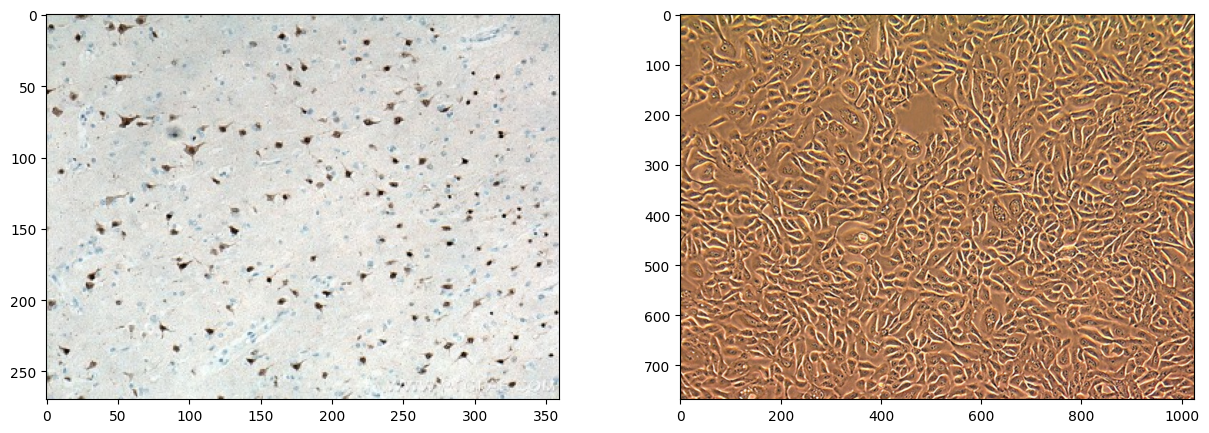

In [ ]:
from skimage import io

# Cargar una imagen
image1antigenandcell = io.imread('/content/image1antigenandcell.jpg')
image2cell = io.imread('/content/image2cell.jpg')
# Mostrar la imagen
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(image1antigenandcell)
axs[1].imshow(image2cell)

io.show()

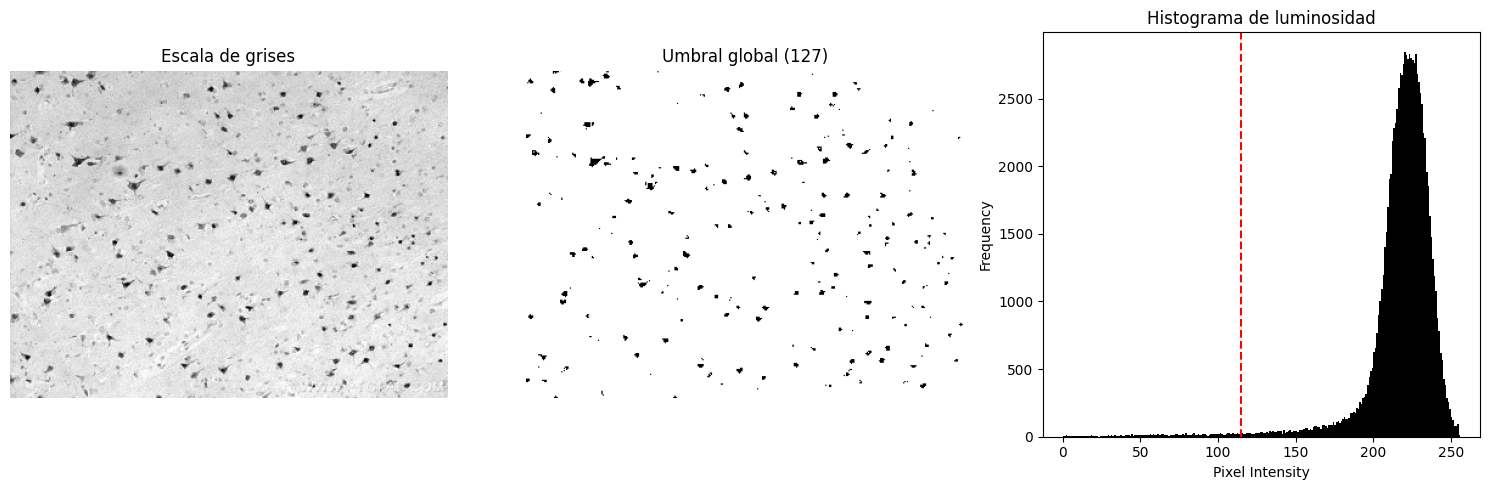

In [ ]:
import cv2

# Convertimos a escala de grises para poder umbralizar de manera global. Solo nos falta elegir un valor de umbral.
gray = cv2.cvtColor(image1antigenandcell, cv2.COLOR_BGR2GRAY)

# Umbral global Ej: valor fijo = 70 de 255 como máx
limite = 115
 # así es más rápido cambiarlo si es necesario
_, th_global = cv2.threshold(gray, limite, 255, cv2.THRESH_BINARY)
# Mostrar resultados
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Primero imprimimos la imagen en gris
axs[0].imshow(gray, cmap="gray")
axs[0].set_title("Escala de grises")
axs[0].axis("off")

# Segundo la linarización global
axs[1].imshow(th_global, cmap="gray")
axs[1].set_title("Umbral global (127)")
axs[1].axis("off")


# Y para hacerlo más visual el histograma de la imagen en gris
axs[2].hist(gray.ravel(), bins=256, range=[0,256], color="black")
axs[2].set_title("Histograma de luminosidad")
axs[2].axvline(limite, color="red", linestyle="--")  # línea en el umbral
axs[2].set_xlabel("Pixel Intensity") # Added x-axis label
axs[2].set_ylabel("Frequency") # Added y-axis label

plt.tight_layout()
plt.show()

Se detectaron 219 manchas en total.


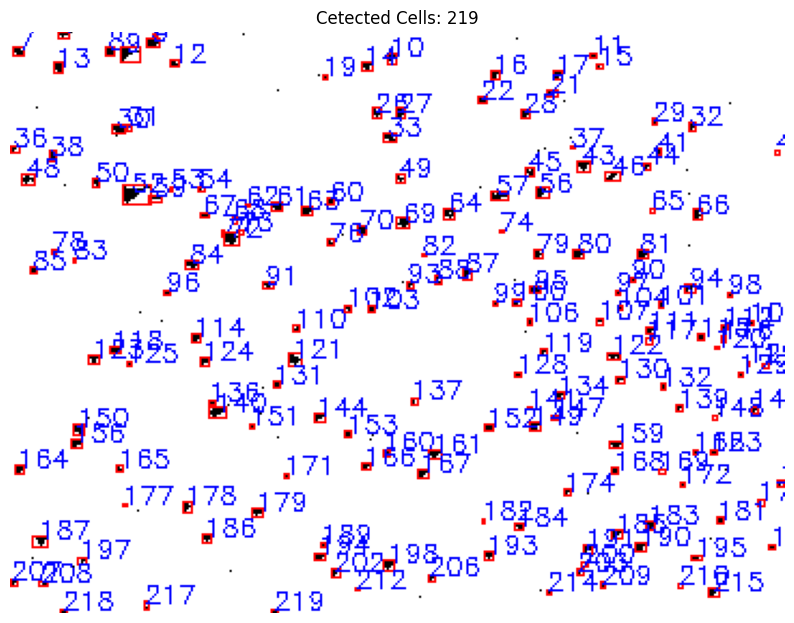

In [ ]:
# --- NUEVO BLOQUE: detección y etiquetado de manchas negras ---

# Invertimos la imagen binaria si es necesario (queremos manchas en blanco sobre fondo negro)
# Esto depende de cómo se generó tu umbral, si ya están en negro puedes quitar esta línea.
th_invertida = cv2.bitwise_not(th_global)

# Detectar componentes conectados (cada mancha individual)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(th_invertida, connectivity=8)

# Crear una copia en color para visualizar los resultados
output = cv2.cvtColor(th_global, cv2.COLOR_GRAY2BGR)

# Dibujar rectángulos y números sobre cada mancha
for i in range(1, num_labels):  # el 0 es el fondo
    x, y, w, h, area = stats[i]
    cx, cy = centroids[i]
    # Filtrar manchas muy pequeñas (opcional, ej. ruido)
    if area > 1:
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 0, 255), 1)
        cv2.putText(output, str(i), (int(cx), int(cy)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)

print(f"Se detectaron {num_labels - 1} manchas en total.")

# Mostrar resultado
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title(f"Cetected Cells: {num_labels - 1}")
plt.axis("off")
plt.show()


In [ ]:
# Extraemos la información de los detalles de la imagen en tuplas:
ancho, alto, capas = image1antigenandcell.shape
print('Ancho: '+str(ancho))
print('Alto: '+str(alto))
print('Capas: '+str(capas))
#Como podemos ver tiene 3 capas

Ancho: 270
Alto: 360
Capas: 3


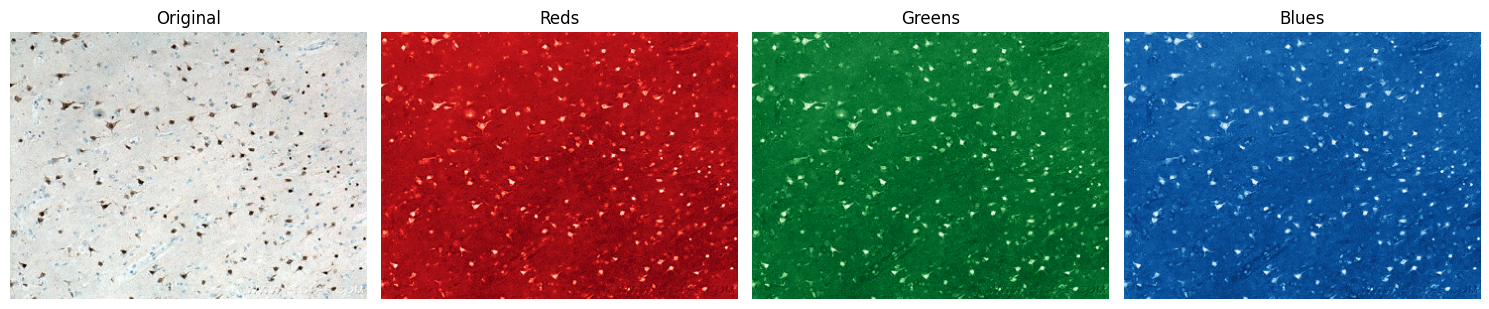

In [ ]:
fig, axs = plt.subplots(1, capas + 1, figsize=(15, 5))



axs[0].imshow(image1antigenandcell)
axs[0].set_title("Original")
axs[0].axis("off")

colores=["Reds", "Greens", "Blues"]
for i in range(capas):
    axs[i+1].imshow(image1antigenandcell[:, :, i], cmap=colores[i])
    axs[i+1].set_title(colores[i])
    axs[i+1].axis("off")

plt.tight_layout() #esta linea solo hace que se ajuste a la página
plt.show()

In [ ]:
# Calculate the average intensity for each channel
red_avg = np.mean(image1antigenandcell[:, :, 0])
green_avg = np.mean(image1antigenandcell[:, :, 1])
blue_avg = np.mean(image1antigenandcell[:, :, 2])

print(f"Average intensity of the Red channel: {red_avg:.2f}")
print(f"Average intensity of the Green channel: {green_avg:.2f}")
print(f"Average intensity of the Blue channel: {blue_avg:.2f}")

# You can also compare them directly
print(f"\nComparison of average intensities:")
print(f"Red vs Green: {red_avg/green_avg:.2f} times Red intensity compared to Green")
print(f"Red vs Blue: {red_avg/blue_avg:.2f} times Red intensity compared to Blue")
print(f"Green vs Blue: {green_avg/blue_avg:.2f} times Green intensity compared to Blue")

Average intensity of the Red channel: 217.17
Average intensity of the Green channel: 217.75
Average intensity of the Blue channel: 213.79

Comparison of average intensities:
Red vs Green: 1.00 times Red intensity compared to Green
Red vs Blue: 1.02 times Red intensity compared to Blue
Green vs Blue: 1.02 times Green intensity compared to Blue


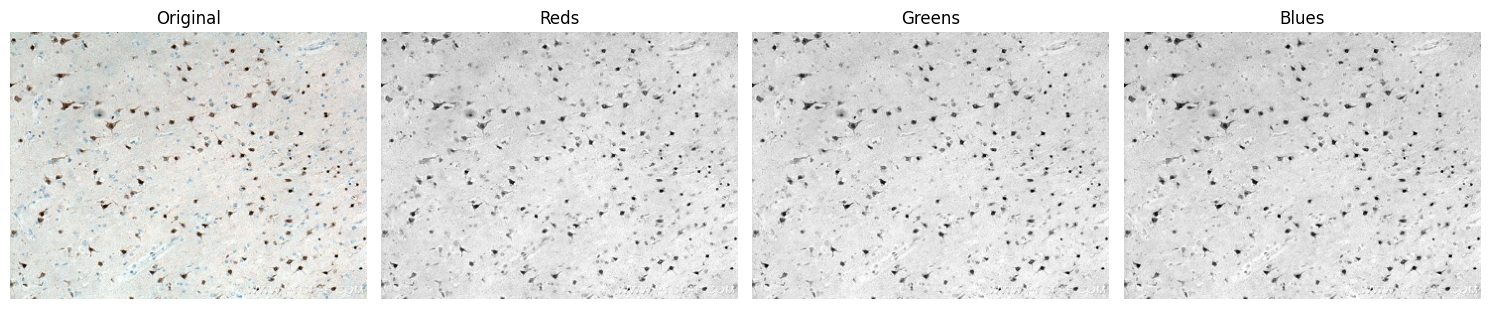

In [ ]:
#En escala de grises
fig, axs = plt.subplots(1, capas + 1, figsize=(15, 5))  # 1 fila, 'capas' columnas



axs[0].imshow(image1antigenandcell)
axs[0].set_title("Original")
axs[0].axis("off")

colores=["Reds", "Greens", "Blues"]
for i in range(capas):
  axs[i+1].imshow(image1antigenandcell[:, :, i], cmap="grey")
  axs[i+1].set_title(colores[i])
  axs[i+1].axis("off")

plt.tight_layout() #esta linea solo hace que se ajuste a la página
plt.show()

#vemos claramente que sí que hay diferencia
